## Imports

Implementation of vanilla GAN from - https://arxiv.org/pdf/1406.2661.pdf

* https://github.com/wiseodd/generative-models/blob/master/GAN/vanilla_gan/gan_pytorch.py
* https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f
* https://github.com/devnag/pytorch-generative-adversarial-networks/blob/master/gan_pytorch.py
* http://www.vision.caltech.edu/visipedia-data/CUB-200/README.txt
* http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
* http://www.vision.caltech.edu/visipedia/CUB-200.html
* http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualize-a-few-images
* https://github.com/pytorch/examples/blob/master/dcgan/main.py
* https://github.com/bamos/dcgan-completion.tensorflow/blob/master/simple-distributions.py (simple test data for rapid prototyping)

In [1]:
import numpy as np
import os
import random
import torch
from PIL import Image
import scipy.misc
from torchvision import datasets, transforms
from torch import nn
from torch.autograd import Variable
import torch.nn.init as init
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.autograd as autograd
import torchvision
import matplotlib as mpl
from tqdm import tqdm
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')
import torchvision.utils as vutils

%matplotlib inline
random.seed(1)
torch.manual_seed(1)

In [51]:
DATA_PATH='/media/bfortuner/bigguy/data/'
CUB_PATH=DATA_PATH+'cub/'
CUB_IMAGES_PATH=CUB_PATH+'images/'
MNIST_PATH=DATA_PATH+'mnist/'
MNIST_WEIGHTS_PATH=MNIST_PATH+'weights/'
MNIST_RESULTS_PATH='results/'

## Files

In [3]:
def get_paths_to_files(dir_path):
    filepaths = []
    fnames = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        filepaths.extend(os.path.join(dirpath, f) for f in filenames if not f[0] == '.')
        fnames.extend([f for f in filenames if not f[0] == '.'])
    return filepaths, fnames

def get_random_image_path(dir_path):
    filepaths = get_paths_to_files(dir_path)[0]
    return filepaths[random.randrange(len(filepaths))]

In [4]:
fpaths,fnames = get_paths_to_files(CUB_IMAGES_PATH)
print(len(fnames))
print(get_random_image_path(CUB_IMAGES_PATH))

6033
/media/bfortuner/bigguy/data/cub/images/024.Red_faced_Cormorant/Red_faced_Cormorant_0008_707313905.jpg


## Images

In [5]:
def load_img_as_pil(img_path):
    return Image.open(img_path)

def load_img_as_np_arr(img_path):
    return scipy.misc.imread(img_path) #scipy

def load_img_as_tensor(img_path):
    pil_image = Image.open(img_path)
    return transforms.ToTensor()(pil_image)

def load_img_as_tensor_w_transforms(img_path, transforms):
    pil_image = Image.open(img_path)
    return transforms(pil_image) #Optionally wrap in Variable()

def plot_np_array(arr_img, fs=(3,3)):
    # fs == inches?)
    plt.figure(figsize=fs)
    plt.imshow(arr_img.astype('uint8'))
    plt.show()

def plot_tensor(tns_img, fs=(3,3)):
    "Takes a normalized tensor [0,1] and plots PIL image"
    pil_from_tns = transforms.ToPILImage()(tns_img)
    plt.figure(figsize=fs)
    plt.imshow(pil_from_tns)
    plt.show()

def plot_pil(pil_img, fs=(3,3)):
    plt.figure(figsize=fs)
    plt.imshow(pil_img)
    plt.show()
    
def get_mean_std_dataset(dir_path, sample_size=5):
    fpaths, fnames = get_paths_to_files(dir_path)
    random.shuffle(fpaths)
    total_mean = np.array([0.,0.,0.])
    total_std = np.array([0.,0.,0.]) 
    for f in fpaths[:sample_size]:
        img_arr = load_img_as_np_arr(f)
        mean = np.mean(img_arr, axis=(0,1))
        std = np.std(img_arr, axis=(0,1))
        total_mean += mean
        total_std += std
    avg_mean = total_mean / sample_size
    avg_std = total_std / sample_size
    print("mean: {}".format(avg_mean))
    print("stdev: {}".format(avg_std))
    return avg_mean, avg_std

def norm_meanstd(t, mean, std):
    """The Pytorch transforms module does this
    Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor
    channel = (channel - mean) / std"""
    return (t-mean) / std

def denorm_meanstd(t, mean, std):
    return (t * std) + mean

def plot_meanstd_normed_np_array(arr, mean, std):
    """If normalized with mean/std"""
    arr = denorm_meanstd(arr, mean, std)
    plot_np_array(arr)

def plot_meanstd_normed(arr, mean, std, title=None):
    """If normalized with mean/std"""
    if type(arr) is not np.ndarray:
        arr = arr.numpy().transpose((1, 2, 0))
    arr = denorm_meanstd(arr, mean, std)
    plt.imshow(arr)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()
    
def save_numpy_img(np_arr, fpath):
    scipy.misc.imsave(fpath, np_arr)

#https://github.com/pytorch/vision/blob/master/torchvision/utils.py#L83
def save_tensor_img(tns, fpath):
    save_image(tns, fpath)
    
def save_img(pill_img, fpath):
    pil_image.save(fpath)

In [6]:
img_path = get_random_image_path(CUB_IMAGES_PATH)
img = load_img_as_pil(img_path)
img_arr = load_img_as_np_arr(img_path)
img_tns = load_img_as_tensor(img_path)

(333, 500, 3)


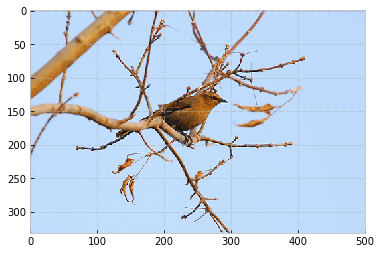

In [7]:
print(img_arr.shape)
plot_np_array(img_arr,(6,6))

## CUB 200

In [8]:
BATCH_SIZE = 4
CUB_MEAN,CUB_STD = get_mean_std_dataset(CUB_IMAGES_PATH,200)

mean: [ 123.28050764  126.2101505   107.53428   ]
stdev: [ 47.73920599  47.50506755  50.86717971]


In [9]:
dataset = datasets.ImageFolder(root=CUB_IMAGES_PATH, 
           transform=transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(CUB_MEAN, CUB_STD),
        ]))

cub_data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True)

cub_class_names = dataset.classes

In [10]:
cub_inputs,cub_classes = next(iter(cub_data_loader))

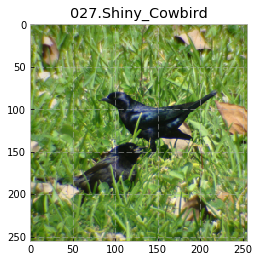

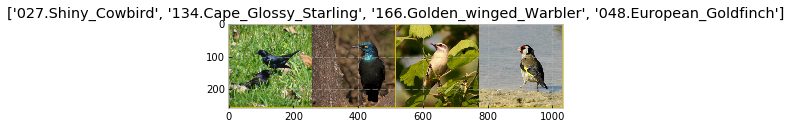

In [11]:
plot_meanstd_normed(cub_inputs[0], CUB_MEAN, CUB_STD, cub_class_names[cub_classes[0]])
# Make a grid from batch
img_grid = torchvision.utils.make_grid(cub_inputs)
plot_meanstd_normed(img_grid, CUB_MEAN, CUB_STD, title=[cub_class_names[x] for x in cub_classes])

## MNIST

In [12]:
MNIST_BATCH_SIZE = 128
MNIST_MEAN = np.array([0.1307,])
MNIST_STD = np.array([0.3081,])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(MNIST_MEAN, MNIST_STD)
                   ])),
    batch_size=MNIST_BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(MNIST_PATH, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(MNIST_MEAN, MNIST_STD)
                   ])),
    batch_size=MNIST_BATCH_SIZE, shuffle=True)

In [13]:
mnist_inputs, mnist_classes = next(iter(train_loader))

In [14]:
img_tns = mnist_inputs[0]

def plot_mnist(arr, title=None):
    """If normalized with mean/std"""
    if type(arr) is not np.ndarray:
        arr = arr.numpy().transpose((1, 2, 0))
    arr = denorm_meanstd(arr, MNIST_MEAN, MNIST_STD)
    arr = arr.reshape((28, 28))
    plt.imshow(arr, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.axis('off')
    plt.show()

def plot_samples(arr, dim=(4,4), figsize=(6,6)):
    if type(arr) is not np.ndarray:
        arr = arr.numpy()
    bs = arr.shape[0]
    arr = arr.reshape(bs, 28, 28)
    plt.figure(figsize=figsize)
    for i,img in enumerate(arr):
        plt.subplot(*dim, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    
img_tns.view(-1).size()

torch.Size([784])

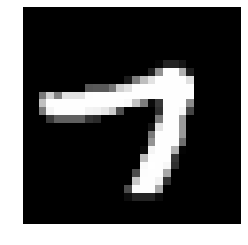

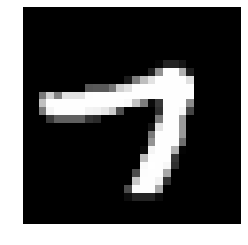

In [15]:
plot_mnist(img_tns)
plot_mnist(img_tns.numpy())

## Model

TODO:
1. Lambda transform to flatten MNIST to 784 - transforms.Lambda(lambda x: x.view(-1))
3. Loss functions - G and D
4. Weight + Bias Initializations - uniform
5. Random Uniform Z noise 100D vector method
6. All code manual with W and B defined raw
7. Train function
8. Test/Generate Sample function
9. Training loop
10. Optimizer - SGD

Design

Discriminator
* Input - 784 flattened vector
* Linear
* ReLU
* Sigmoid

Generator
* Input - 100D Flattened Vector
* Linear (or Conv2d)
* ReLU
* Linear (or Conv2d)
* Sigmoid

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(784,300)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(300,300)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(300,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(100, 200)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(200, 400)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [17]:
def weights_init(m):
    init.xavier_uniform(m.weight.data) 
    m.bias.data.zero_() #does this by default?
    
def get_noise(batch_size, dim=100):
    return torch.rand((batch_size, dim)).cuda()

In [18]:
print(Generator())
print(Discriminator())

Generator (
  (linear1): Linear (100 -> 200)
  (relu1): ReLU ()
  (linear2): Linear (200 -> 400)
  (relu2): ReLU ()
  (linear3): Linear (400 -> 784)
  (sigmoid): Sigmoid ()
)
Discriminator (
  (linear1): Linear (784 -> 300)
  (relu1): ReLU ()
  (linear2): Linear (300 -> 300)
  (relu2): ReLU ()
  (linear3): Linear (300 -> 1)
  (sigmoid): Sigmoid ()
)


## Train

In [322]:
D = Discriminator().cuda()
G = Generator().cuda()
#D.apply(weights_init)
#G.apply(weights_init)
criterion = nn.BCELoss().cuda()
D_optimizer = optim.Adam(D.parameters(), lr=1e-4)
G_optimizer = optim.Adam(G.parameters(), lr=1e-4)
real_labels = Variable(torch.ones(batch_size,1).cuda())
fake_labels = Variable(torch.zeros(batch_size,1).cuda())

In [323]:
def train(D, G, D_optimizer, G_optimizer, criterion, train_loader, epoch):
    
    total_D_loss = 0
    total_G_loss = 0
    for inputs,targets in train_loader:
        inputs,targets = Variable(inputs.cuda()), Variable(targets.cuda())
        batch_size = len(inputs)
        inputs = inputs.view(batch_size,-1)

        
        ### Discriminator ###
        # maximize log(D(x)) + log(1 - D(G(z)))
        D.zero_grad()
        
        #Real
        real_out = D(inputs)
        D_loss_real = criterion(real_out, real_labels)
        
        #Fake
        noise = Variable(get_noise(batch_size, 100))
        fake = G(noise).detach() #Set compute_gradient=False to avoid training G
        fake_out = D(fake)
        D_loss_fake = criterion(fake_out, fake_labels)
        
        D_loss = D_loss_real + D_loss_fake
        
        D_loss.backward()
        D_optimizer.step()
        
        
        ### Generator ###
        #  maximize log(D(G(z)))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights
        # of the model)
        G.zero_grad()
            
        noise = Variable(get_noise(batch_size, 100))
        out = D(G(noise))
        G_loss = criterion(out, real_labels)
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        G_loss.backward()
        
        # Calling the step function on an Optimizer makes an update to its parameters
        G_optimizer.step()
        
        total_D_loss += D_loss.data[0]
        total_G_loss += G_loss.data[0]
        
    mean_D_loss = total_D_loss/len(train_loader)
    mean_G_loss = total_G_loss/len(train_loader)
    
    # do checkpointing
    torch.save(D.state_dict(), '%sD_latest.pth' % (MNIST_WEIGHTS_PATH))
    torch.save(G.state_dict(), '%sG_latest.pth' % (MNIST_WEIGHTS_PATH))
    return mean_D_loss, mean_G_loss
    
def predict(G, samples=4):
    noise = Variable(get_noise(samples,100), volatile=True)
    samples = G(noise)
    return samples.data.cpu()

In [324]:
EPOCHS=100

loss_history = []
for epoch in tqdm(range(1,EPOCHS+1)):
    D_loss, G_loss = train(D, G, D_optimizer, G_optimizer, criterion, train_loader, epoch)
    loss_history.append([D_loss.data[0], G_loss.data[0]])

100%|██████████| 100/100 [07:47<00:00,  4.70s/it]


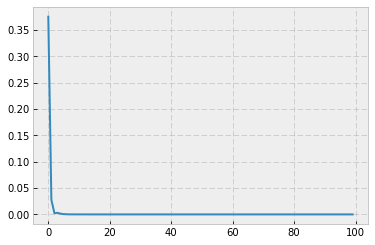

In [325]:
loss_history = np.array(loss_history)
plt.plot(loss_history[:,0])

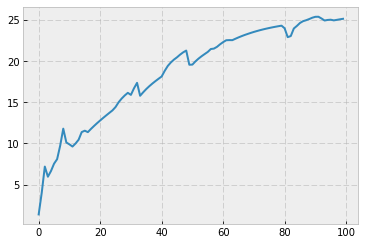

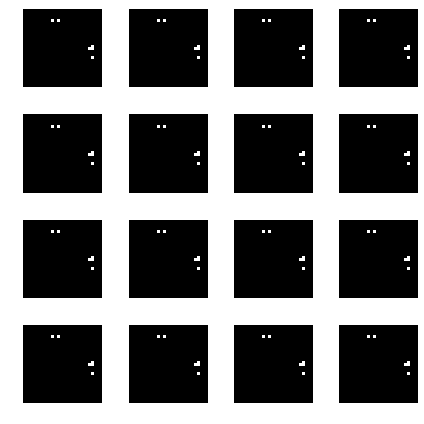

In [326]:
plt.plot(loss_history[:,1])
samples = predict(G,16)
plot_samples(samples)

# DCGAN

In [19]:
# Use the 1,28,28 MNIST images 

def get_noise(batch_size, vec_size):
    return Variable(torch.FloatTensor(
        batch_size, vec_size, 1, 1).normal_(0,1).cuda())
    
def weights_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        init.normal(m.weight.data, mean=0, std=0.2)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal(m.weight.data, mean=1, std=0.2)
        m.bias.data.zero_()

class G_Block(nn.Sequential):
    def __init__(self, in_chans, out_chans, f_size, stride, pad):
        super(G_Block, self).__init__()
        self.convTrans = nn.ConvTranspose2d(
            in_chans, out_chans, f_size, stride, pad, bias=False)
        self.batchNorm = nn.BatchNorm2d(out_chans)
        self.ReLU = nn.ReLU(True)

class netG(nn.Module):
    def __init__(self, in_chans, out_chans):
        super(netG, self).__init__()
        self.block1 = G_Block(in_chans, 256, 7, stride=1, pad=0)
        self.block2 = G_Block(256, 128, 4, stride=2, pad=1)
#         self.block3 = G_Block(256, 128, 4, stride=2, pad=1)
#         self.block4 = G_Block(128, 64, 4, stride=2, pad=1)
        self.convTrans = nn.ConvTranspose2d(
            128, out_chans, 4, stride=2, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        #print (x.size())
        out = self.block1(x)
        #print(out.size())
        out = self.block2(out)
        #print(out.size())
#         out = self.block3(out)
#         print(out.size())
#         out = self.block4(out)
#         print(out.size())
        out = self.convTrans(out)
        #print(out.size())
        out = self.tanh(out)
        return out

class D_Block(nn.Sequential):
    def __init__(self, in_chans, out_chans, f_size, stride, pad, bn=True):
        super(D_Block, self).__init__()
        self.conv = nn.Conv2d(
            in_chans, out_chans, f_size, stride, pad, bias=False)
        if bn:
            self.bn = nn.BatchNorm2d(out_chans)
        self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

class netD(nn.Module):
    def __init__(self, in_chans):
        super(netD, self).__init__()
        self.block1 = D_Block(in_chans, 64, 4, stride=2, pad=1, bn=False)
        self.block2 = D_Block(64, 128, 4, stride=2, pad=1)
        self.block3 = D_Block(128, 256, 4, stride=2, pad=1)
        #self.block4 = D_Block(256, 512, 4, stride=2, pad=1)
        self.conv = nn.Conv2d(256, 1, 3, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print(x.size())
        out = self.block1(x)
        #print(out.size())
        out = self.block2(out)
        #print(out.size())
        out = self.block3(out)
        #print(out.size())
        #out = self.block4(out)
        #print(out.size())
        out = self.conv(out)
        #print(out.size())
        out = self.sigmoid(out)
        return out.view(-1,1)

In [20]:
print(netG(100, 1))
print(netD(1))

netG (
  (block1): G_Block (
    (convTrans): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (batchNorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (ReLU): ReLU (inplace)
  )
  (block2): G_Block (
    (convTrans): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batchNorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (ReLU): ReLU (inplace)
  )
  (convTrans): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh ()
)
netD (
  (block1): D_Block (
    (conv): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu): LeakyReLU (0.2, inplace)
  )
  (block2): D_Block (
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (relu): LeakyReLU (0.2, inplace)
  )
  (block3): D_Block (
    (conv): Conv2d(128, 256, kernel_s

## Train

* generator in_channels = 100 flat, uniform distribution (projected to a small spacial extense conv representation with many feature maps)
* Weight_Init = zero-centered, normal distribution with Std deviation of 0.2
* Optimizer = Adam (lr=2e-4, momentum=0.5)
* mini_batch_size = 128
* Training images were scaled to the range of the tanh activation function [-1, 1]

In [21]:
cudnn.benchmark = True

noise_vec_size = 100 #input to generator
batch_size = 128

D = netD(1).cuda()
G = netG(noise_vec_size, 1).cuda()
D.apply(weights_init)
G.apply(weights_init)

# both are evaluated with a 1/0 answer from discriminator
criterion = nn.BCELoss().cuda() 
D_optimizer = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

fixed_noise = Variable(torch.FloatTensor(
    batch_size, noise_vec_size, 1, 1).normal_(0,1).cuda())

In [47]:
def train(G, D, criterion, G_optim, D_optim, dataloader, epochs):
    n_batches = len(dataloader)
    D_total_loss = 0
    G_total_loss = 0
    for inputs,targets in train_loader:
        batch_size = len(inputs)
        real_imgs = Variable(inputs.cuda())
        real_labels = Variable(torch.ones(batch_size,1).cuda())
        fake_labels = Variable(torch.zeros(batch_size,1).cuda())

        # Clear gradients
        D.zero_grad()
        G.zero_grad()
        
        ## Discriminator - Real
        D_real_out = D(real_imgs)
        D_real_loss = criterion(D_real_out, real_labels)
        D_real_loss.backward()
        
        ## Discriminator - Fake
        noise = get_noise(batch_size, noise_vec_size)
        D_fake_out = D(G(noise).detach())
        D_fake_loss = criterion(D_fake_out, fake_labels)

        D_fake_loss.backward()
        D_optim.step()
        
        D_loss = D_real_loss + D_fake_loss
        
        ## Generator
        G_out = D(G(noise))
        G_loss = criterion(G_out, real_labels)
        
        G_loss.backward()
        G_optim.step()
        
        D_total_loss += D_loss.data[0] / n_batches
        G_total_loss += G_loss.data[0] / n_batches
        
        # do checkpointing
    torch.save(D.state_dict(), '%sD_latest.pth' % (MNIST_WEIGHTS_PATH))
    torch.save(G.state_dict(), '%sG_latest.pth' % (MNIST_WEIGHTS_PATH))
    return D_total_loss, G_total_loss

def test(G, out_path, epoch=1):
    fake = G(fixed_noise)
    vutils.save_image(fake.data.cpu(),
            '%s/fake_samples_epoch_%03d.png' % (out_path, epoch),
            normalize=True)
    return fake.data.cpu()

def plot_fake_samples(G, n_samples=12):
    fake = G(fixed_noise).data.cpu()
    plot_samples(fake[:12])

In [23]:

train(G, D, criterion, G_optimizer, D_optimizer, train_loader, 1)

(0.13313891122421453, 9.418092436881977)

In [41]:
fake_samples = test(G, MNIST_RESULTS_PATH) #entire batch

torch.Size([128, 1, 28, 28])
<class 'torch.FloatTensor'>


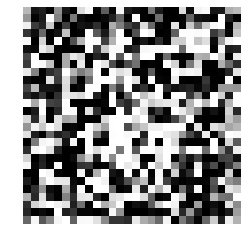

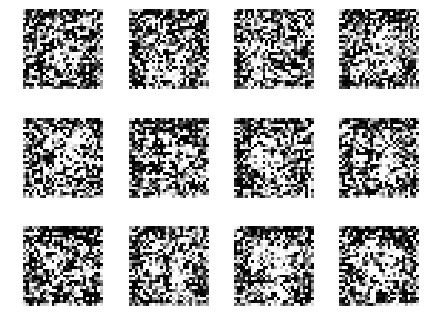

In [44]:
print (fake_samples.size())
print(type(fake_samples[0]))
plot_mnist(fake_samples[0])
plot_samples(fake_samples[:12])

## Run Loop

In [46]:
EPOCHS=300

loss_history = []
for epoch in tqdm(range(1,EPOCHS+1)):
    D_loss, G_loss = train(G, D, criterion, G_optimizer, D_optimizer, train_loader, epoch)
    loss_history.append([D_loss, G_loss])


100%|██████████| 10/10 [06:16<00:00, 37.62s/it]


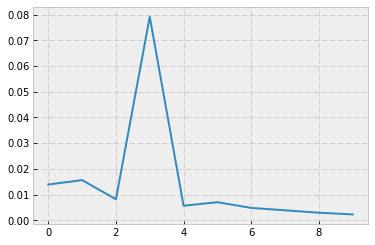

In [48]:
loss_history = np.array(loss_history)
plt.plot(loss_history[:,0])

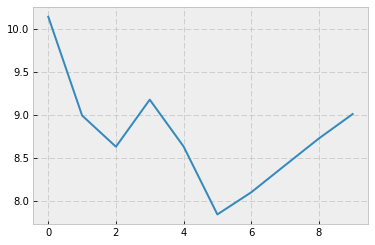

In [49]:
plt.plot(loss_history[:,1])

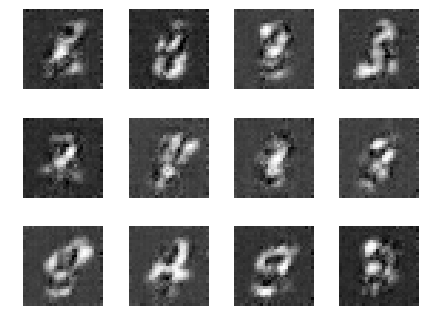

In [50]:
plot_fake_samples(G)